In [2]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [13]:
n = 8
n_node = 6

In [4]:
K = tc.set_backend('jax')

In [5]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = y == a
    return x, y

In [6]:
def loss(params, x, y, k, out):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = (jnp.real(c.expectation([tc.gates.z(), [out,]])) + 1) / 2
    return -(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
loss = K.jit(loss, static_argnums=[3, 4])

In [7]:
def accuracy(params, x, y, k, out):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [out,]])) + 1) / 2)
    return y_pred == y
accuracy = K.jit(accuracy, static_argnums=[3, 4])

In [8]:
k = 6

In [9]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/99: loss=0.6646, acc=0.6797
epoch 0, 30/99: loss=0.5164, acc=0.9297
epoch 0, 60/99: loss=0.4778, acc=0.8203
epoch 0, 90/99: loss=0.4779, acc=0.8750
epoch 1, 0/99: loss=0.4616, acc=0.9141
epoch 1, 30/99: loss=0.3790, acc=0.9688
epoch 1, 60/99: loss=0.3933, acc=0.9844
epoch 1, 90/99: loss=0.3938, acc=0.9453


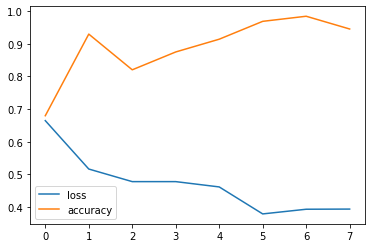

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/93: loss=0.6792, acc=0.6172
epoch 0, 30/93: loss=0.5599, acc=0.9219
epoch 0, 60/93: loss=0.5508, acc=0.9375
epoch 0, 90/93: loss=0.5174, acc=0.9844
epoch 1, 0/93: loss=0.5281, acc=0.9609
epoch 1, 30/93: loss=0.5157, acc=0.9375
epoch 1, 60/93: loss=0.5265, acc=0.9141
epoch 1, 90/93: loss=0.4977, acc=0.9609


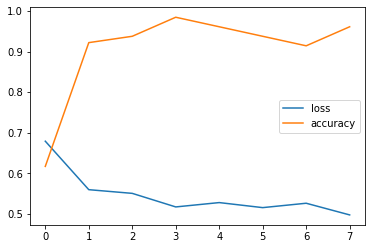

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/95: loss=0.6881, acc=0.5312
epoch 0, 30/95: loss=0.5607, acc=0.9609
epoch 0, 60/95: loss=0.5171, acc=0.9688
epoch 0, 90/95: loss=0.4948, acc=0.9766
epoch 1, 0/95: loss=0.5114, acc=0.9609
epoch 1, 30/95: loss=0.4962, acc=0.9766
epoch 1, 60/95: loss=0.4785, acc=0.9688
epoch 1, 90/95: loss=0.4756, acc=0.9453


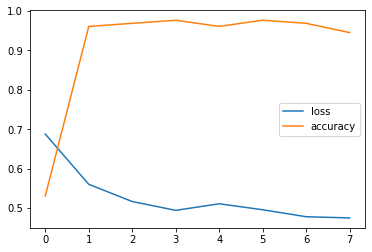

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/92: loss=0.7021, acc=0.5625
epoch 0, 30/92: loss=0.5452, acc=0.9766
epoch 0, 60/92: loss=0.4980, acc=1.0000
epoch 0, 90/92: loss=0.4623, acc=0.9766
epoch 1, 0/92: loss=0.4866, acc=0.9922
epoch 1, 30/92: loss=0.4437, acc=0.9922
epoch 1, 60/92: loss=0.4627, acc=0.9688
epoch 1, 90/92: loss=0.4300, acc=1.0000


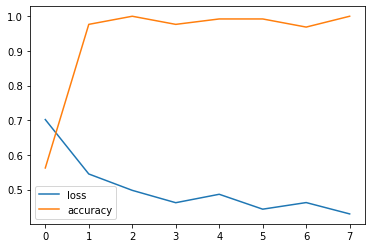

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/89: loss=0.6902, acc=0.6016
epoch 0, 30/89: loss=0.5936, acc=0.7969
epoch 0, 60/89: loss=0.5795, acc=0.8594
epoch 1, 0/89: loss=0.5367, acc=0.9531
epoch 1, 30/89: loss=0.5179, acc=0.9219
epoch 1, 60/89: loss=0.5222, acc=0.9531


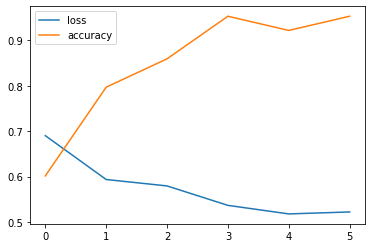

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/93: loss=0.6759, acc=0.6641
epoch 0, 30/93: loss=0.5610, acc=0.9766
epoch 0, 60/93: loss=0.5273, acc=0.9141
epoch 0, 90/93: loss=0.4792, acc=0.9453
epoch 1, 0/93: loss=0.4616, acc=0.9766
epoch 1, 30/93: loss=0.4250, acc=0.9766
epoch 1, 60/93: loss=0.4363, acc=0.9141
epoch 1, 90/93: loss=0.4054, acc=0.9688


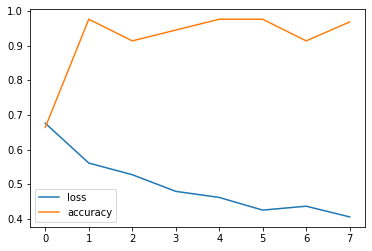

In [10]:
params_list = []
for node in tqdm(range(n_node)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    data = tf.data.Dataset.from_tensor_slices((x_train_small, y_train_node)).shuffle(100).batch(128)

    params = K.randn((k * 2, n), dtype=jnp.float32)
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)

    loss_list = []
    acc_list = []
    for e in tqdm(range(2)):
        for i, (x, y) in enumerate(data):
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params, x, y, k, node)
            updates, opt_state = opt.update(grad_val, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss_mean = jnp.mean(loss_val)
            if i % 30 == 0:
                acc = jnp.mean(compute_accuracy(params, x, y, k, node))
                acc_list.append(acc)
                loss_list.append(loss_mean)
                print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

    plt.plot(loss_list)
    plt.plot(acc_list)
    plt.legend(['loss', 'accuracy'])
    plt.show()

    params_list.append(params)


In [11]:
def pred(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2)
    return y_pred
pred = K.jit(pred, static_argnums=[3])

In [14]:
density_est_list = []
p_node = []
for node in tqdm(range(n_node)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    dm = jnp.einsum('nij, njk -> nik', jnp.conjugate(x_train_small.reshape(-1, 2**n, 1)), x_train_small.reshape(-1, 1, 2**n))
    density_est_list.append(jnp.mean(dm, axis=0))
    p_node.append(len(x_train_small))
density_est_list = jnp.stack(density_est_list, axis=0)
p_node = jnp.stack(p_node, axis=0) / jnp.sum(jnp.array(p_node))

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
jnp.trace(density_est_list[0]@density_est_list[1])

DeviceArray(0.21194997, dtype=float32)

In [15]:
p_node

DeviceArray([0.17700909, 0.16605172, 0.16846961, 0.16443047, 0.15854648,
             0.16549267], dtype=float32)

In [45]:
def pred_comb(params, x, k):
    dm_list = []
    for node in range(n_node):
        c = tc.Circuit(n, inputs=x)
        for j in range(k):
            for i in range(n - 1):
                c.cnot(i, i + 1)
            for i in range(n):
                c.rx(i, theta=params[node][2 * j, i])
                c.ry(i, theta=params[node][2 * j + 1, i])
        density_matrix = jnp.conjugate(c.wavefunction('ket')) @ c.wavefunction('bra')
        dm_list.append(density_matrix)

    projector = jnp.conjugate(x.reshape(-1, 1)) @ x.reshape(1, -1)
    weight = jnp.einsum('nij, ji -> n', density_est_list, projector).reshape(-1, 1, 1) * p_node.reshape(-1, 1, 1)
    weight = weight / jnp.sum(weight)

    # dm = jnp.sum(jnp.stack(dm_list, axis=0) * weight, axis=0)
    # # print(jnp.trace(dm))
    # c = tc.DMCircuit(n, dminputs=dm)
    # pred_prob = []
    # for node in range(6):
    #     pred_prob.append((jnp.real(c.expectation([tc.gates.z(), [node,]])) + 1) / 2)

    pred_prob = []
    for node in range(n_node):
        c = tc.DMCircuit(n, dminputs=dm_list[node])
        pred_prob.append(1-(jnp.real(c.expectation([tc.gates.z(), [node,]])) + 1) / 2)

    print(pred_prob)
    print(weight)
    pred_prob = jnp.stack(pred_prob, axis=0) * weight.reshape(-1)
    pred_prob = jnp.hstack([1-jnp.sum(pred_prob), pred_prob])

    return pred_prob
# pred_comb = K.jit(pred_comb, static_argnums=[2])

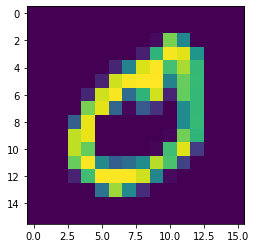

In [48]:
i = 4
x_train_node, y_train_node = filter_pair(x_train, y_train, 0, 2 + 1)
x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
plt.imshow(x_train_small[i].reshape(16, 16))

In [49]:
pred_comb(params_list, x_train_small[i], k)

[DeviceArray(0.36652964, dtype=float32), DeviceArray(0.3464694, dtype=float32), DeviceArray(0.34825933, dtype=float32), DeviceArray(0.29683363, dtype=float32), DeviceArray(0.34602463, dtype=float32), DeviceArray(0.2708165, dtype=float32)]
[[[0.15557137]]

 [[0.16448471]]

 [[0.17769487]]

 [[0.15670694]]

 [[0.17868209]]

 [[0.16686006]]]


DeviceArray([0.6705729 , 0.05702152, 0.05698892, 0.0618839 , 0.04651589,
             0.0618284 , 0.04518846], dtype=float32)

In [39]:
prediction = K.vmap(pred, vectorized_argnums=[1, 2])(params, x_train_small[:1000], y_train[:1000], k)

In [40]:
jnp.mean(y_train[:1000]*1.0==prediction)

DeviceArray(0.92, dtype=float32)